In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lendingclub import config
import seaborn as sns

pd.set_option('max_columns', 999)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

ppath = config.prj_dir
dpath = config.data_dir

In [2]:
all_scores = pd.read_feather(os.path.join(config.data_dir, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(config.data_dir, 'base_loan_info.fth'))
with open(os.path.join(config.data_dir, 'train_test_ids.pkl'), 'rb') as f:
    train_test_ids = pickle.load(f)
print(all_scores.shape, base_loan_info.shape)

(2507335, 48) (2507335, 90)


# USE TEST IDS TO GENERATE DISTRIBUTIONS OF END_M

In [3]:
# examine the distribution of high maturity time loans for which months they default and prepay
test_id = train_test_ids['test'] # <- test ids
ddone_loans = all_scores.query('id in @test_id and maturity_time >= .95 and loan_status in ["defaulted", "charged_off", "paid"]')
ddone_loans['months_recorded'] = ((ddone_loans['end_d'] - ddone_loans['issue_d'])/np.timedelta64(1, 'M')).round()
ddone_loans['pct_term'] = ddone_loans['months_recorded']/ddone_loans['term']
def_statuses = ['charged_off', 'defaulted']
def_loans = ddone_loans.query('loan_status in @def_statuses')
paid_loans = ddone_loans.query('loan_status not in @def_statuses')

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


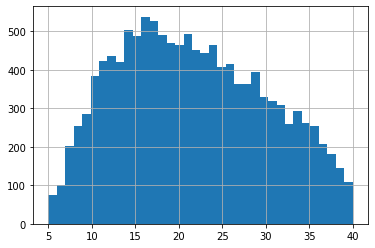

In [4]:
# check how long loans pay for if defaulting or paying for 36 term loans
query = 'term == 36 and months_recorded <= 40 and maturity_time >= .95'
def_probs = (def_loans.query(query)['months_recorded'].value_counts(dropna=False)/len(def_loans.query(query))).to_dict()
def_m, def_prob = zip(*def_probs.items())
ddef_loans = def_loans.query(query)
ddef_loans['months_recorded'].hist(bins=36)

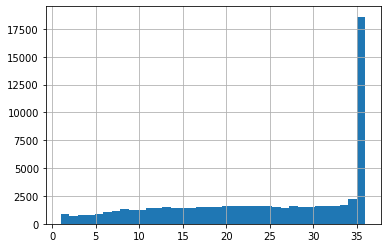

In [5]:
query = 'term == 36 and months_recorded <= 36 and months_recorded >= 1 and maturity_time >= .95'
paid_probs = (paid_loans.query(query)['months_recorded'].value_counts(dropna=False)/len(paid_loans.query(query))).to_dict()
paid_m, paid_prob = zip(*paid_probs.items())
dpaid_loans = paid_loans.query(query)
dpaid_loans['months_recorded'].hist(bins=36)

# is there any correlation between the int_rate/grade of a defaulting/paying loan and when its end_m is? Do loans of different int_rate have different distributions?

In [6]:
term_grade_df = ddone_loans.set_index(['term','grade'])
def_term_grade_df = term_grade_df.query('loan_status in ["defaulted", "charged_off"]')
paid_term_grade_df = term_grade_df.query('loan_status not in ["defaulted", "charged_off"]')
print(term_grade_df.shape, def_term_grade_df.shape, paid_term_grade_df.shape)

(98842, 48) (15927, 48) (82915, 48)


In [7]:
def plot_by_group(df, term, group_cols, target_col, size=(6,5), hist_alpha=.25):
    fig, ax = plt.subplots(figsize=size)
    df.loc[term,:].groupby(group_cols)[target_col].plot(kind='kde', alpha=1, ax=ax,)
    df.loc[term,:].groupby(group_cols)[target_col].plot(kind='hist', alpha=hist_alpha, density=True, ax=ax)
    ax.legend()
    plt.show()

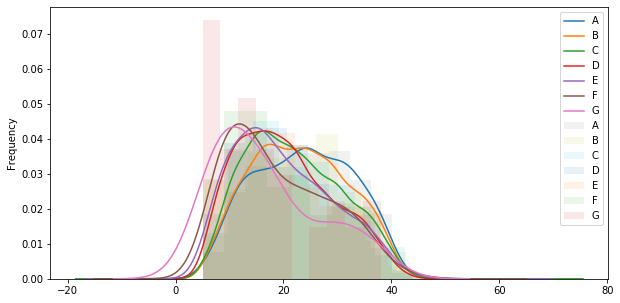

In [8]:
plot_by_group(def_term_grade_df, 36, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

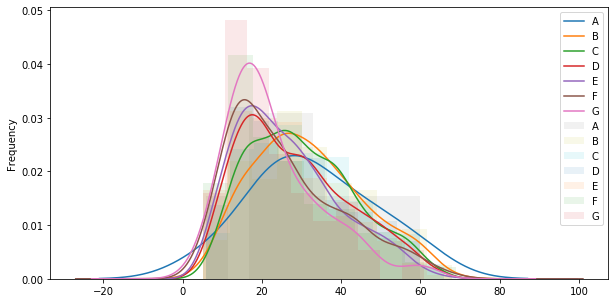

In [9]:
plot_by_group(def_term_grade_df, 60, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

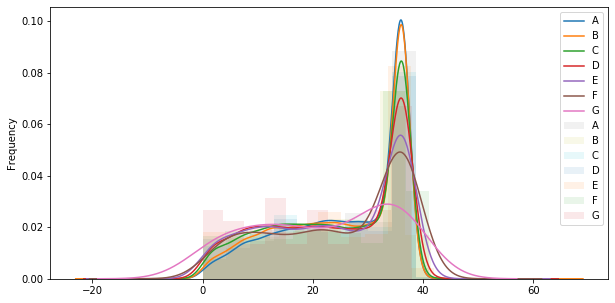

In [10]:
plot_by_group(paid_term_grade_df, 36, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

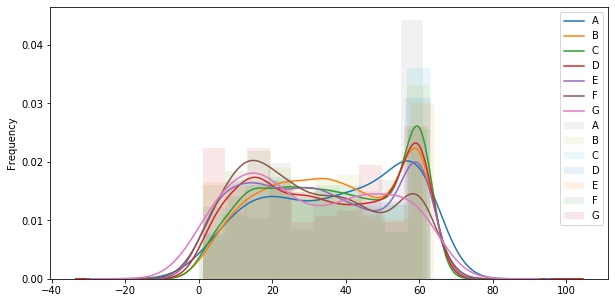

In [11]:
plot_by_group(paid_term_grade_df, 60, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

# depending on grade, the distributions of when the loan ends differs. Need to index by term, def/paid, grade

In [12]:
# for purposes here, rename defaulted to charged_off
ddone_loans.loan_status.replace({'defaulted':'charged_off'}, inplace=True)
ddone_loans.loan_status.unique()

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


array(['paid', 'charged_off'], dtype=object)

In [36]:
end_d_by_term_stat_grade = {}
for term in ddone_loans.term.unique():
    for status in ddone_loans.loan_status.unique():
        for grade in ddone_loans.grade.unique():
            query = 'term == @term and loan_status == @status and grade == @grade'
            loans = ddone_loans.query(query)
            loans = loans.query('months_recorded <= {0}'.format(term + 5))
            ms, probs = zip(*loans.months_recorded.value_counts(normalize=True).to_dict().items())
            end_d_by_term_stat_grade[(term,status,grade)] = (ms, probs)

In [38]:
config.prj_dir

'/home/justin/projects/lendingclub'

In [39]:
with open(os.path.join(config.data_dir, 'end_d_by_term_stat_grade.pkl'), 'wb') as f:
    pickle.dump(end_d_by_term_stat_grade, f)

# writing module below

In [16]:
# Let's model some portfolios

In [17]:
sel_loans = ddone_loans.sample(7)
sel_loans[['loan_status', 'grade', 'term', 'int_rate']]

,loan_status,grade,term,int_rate
1101260,paid,B,36,0.0839
1116657,paid,B,36,0.1149
493620,paid,B,36,0.0867
840234,paid,C,36,0.1367
268185,paid,C,36,0.1464
194520,paid,B,36,0.1099
792521,paid,A,36,0.0789


In [43]:
%%writefile ../../lendingclub/modeling/portfolio_simulating.py
import numpy as np

def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, theoretic = False, end_m = None):
    '''
    it takes 5 months to go from nonpaying to charged_off (90 days late, 120 default, 150 charged off)
    3 l_types:
    A) default immediately, take 5 months
    B) Fully Prepay between 6-12 months. 
    C) Fully Prepay/pay between 24-36 months
    month: what month the loan was invested in (starts at 0 aka 0 indexed)
    end_m is what month the loan willl end relative to month.
    '''
    if theoretic:
        add_m = np.random.choice(np.arange(-3,4))
        if l_type == 'A':
            add_cfs = np.zeros(1)
        else:
            if l_type == 'B':
                n_m = 9+add_m+1
                print(n_m)
            elif l_type == 'C':
                n_m = 33+add_m+1
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (n_m+1))
            rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
            add_cfs[-1] += rem_princp
        add_cfs[0] = funded
        cfs[month:month+len(add_cfs)] += add_cfs
        return cfs
    else:
        assert end_m is not None, "Pass the months on books/months recorded as end_m"
        # Only 2 l_types 'A' default and 'B' (pre)paid, use end_m
        if l_type == 'charged_off':
            n_m = end_m
            add_cfs = np.tile(pmt, int(n_m - (4)))
        elif l_type == 'paid':
            n_m = end_m
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (int(n_m+1)))
            rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
            add_cfs[-1] += rem_princp
        else:
            print('unrecognized loan type')
        add_cfs[0] = funded
        cfs[month:month+len(add_cfs)] += add_cfs
        return cfs


def sim_portfolio(end_d_by_term_stat_grade, sel_loans, n_months=120, n_inv_loans=2000, cfs=None, funded=-1,
                random_state=42, verbose=False, longest_winddown = 76, wait_for_cont=False):
    '''
    Simulate a portfolio for INVESTING for n_months. Actual portfolio winddown
    may take up to 36 months from last investment date
    funded is the loan amount that will be used (e.g. -1 is one dollar funded to loan)
    Args:
        end_d_by_term_stat_grade: dict pickled from 11_portfolio_simulating.ipynb \
        keys are (term, l_stat, grade) and value = tuple(end_m, probability)
        sel_loans: loans that you can possibly invest in. Samples from this for (term,l_stat, grade)
        funded: should be negative
    '''
    # limit it to relevant columns
    sel_loans=sel_loans[['loan_status', 'grade', 'term', 'int_rate']]
    
    cfs=np.zeros(n_months + longest_winddown) if cfs is None else cfs
    end_i = 0
    for month in range(n_months):
        # end_i keeps track of when you have enough money to reinvest
        if month == end_i:
            if verbose:
                print('month is {0} *************************'.format(month))
            # iterate over loans and construct the cfs array
            n_inv_loans = int(np.floor(n_inv_loans))
            starting_money = abs(n_inv_loans*funded)
            loans = sel_loans.sample(n=n_inv_loans, replace=True, random_state=random_state).to_dict('records')
            li_tups = [((l['term'], l['loan_status'], l['grade']), l['int_rate']) for l in loans]
            for l in li_tups:
                # pick the end_m
                key, rate = l
                ms, probs = end_d_by_term_stat_grade[key]
                end_m = np.random.choice(ms, replace=True, p=probs)
                # key is term, stat, grade
                term, stat, grade = key
                pmt = np.pmt(rate/12, term, funded, 0)
                cfs = make_loan_array(stat, funded, pmt, rate/12, term, month, cfs, theoretic=False, end_m=end_m)
                if verbose:
                    print('picking a loan with term: {0}, status: {1}, grade: {2}, and rate: {3}'.format(*key, rate))
                    print('loan life is {0} ending in month {1}'.format(end_m, end_m+month))
                    if wait_for_cont:
                        import ipdb; ipdb.set_trace()
            if verbose:
                print('invested in {0} loans this month'.format(n_inv_loans))
                print('current cfs: {0}'.format(cfs))
                print('current IRR: {0}'.format(np.irr(cfs)*12))
                print('current unadjusted net money: {0}'.format(np.sum(cfs)))
            # calculate which month can reinvest next in
            leftover_money = starting_money - (n_inv_loans * abs(funded))
            assert leftover_money >= 0, 'somehow negative leftover money'
            end_i = month+1
            while (leftover_money < abs(funded)) and (end_i < len(cfs)):
                leftover_money += cfs[end_i]
                end_i += 1
            n_inv_loans = abs(leftover_money/funded)
    # returns the cfs, the net money made, and the annualized irr
    return cfs, np.sum(cfs), np.irr(cfs)*12

Overwriting ../../lendingclub/modeling/portfolio_simulating.py


In [19]:
n_months = 30
month = 3
cfs=np.zeros(n_months + 37)
funded = -1
rate = .07/12
term = 36
theoretic = False
pmt = np.pmt(rate, term, funded)
make_loan_array('paid', funded, pmt, rate, term, month, cfs, end_m = 10, theoretic=theoretic)

array([0.000, 0.000, 0.000, -1.000, 0.031, 0.031, 0.031, 0.031, 0.031,
       0.031, 0.031, 0.031, 0.031, 0.771, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000])

In [20]:
sel_loans['loan_status']

1101260    paid
1116657    paid
493620     paid
840234     paid
268185     paid
194520     paid
792521     paid
Name: loan_status, dtype: object

In [25]:
ddone_loans

,end_d,issue_d,maturity_paid,maturity_time,maturity_time_stat_adj,maturity_paid_stat_adj,rem_to_be_paid,roi_simple,target_loose,target_strict,loan_status,id,grade,sub_grade,term,int_rate,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,catboost_both_score,months_recorded,pct_term
8,2013-03-01,2010-03-01,1.000000,1.000000,1.0,1.0,0.000000,1.214850,0,0,paid,57245,C,C2,36,0.1311,0.127692,0.110950,0.094550,0.078486,0.062750,0.047333,0.032228,0.017427,0.002924,-0.011288,-0.025216,-0.038868,-0.052248,-0.065365,-0.078222,-0.090828,-0.103187,-0.115305,-0.127188,-0.138841,-0.150269,-0.161477,-0.172471,-0.183255,-0.193834,-0.204213,-0.214395,-0.224386,-0.234190,-0.243811,-0.253253,-999.000000,36.0,1.000000
13,2012-03-01,2010-02-01,1.000000,1.000000,1.0,1.0,0.000000,1.112901,0,0,paid,61390,A,A5,36,0.0788,0.039417,0.025492,0.011811,-0.001630,-0.014835,-0.027810,-0.040558,-0.053085,-0.065394,-0.077490,-0.089377,-0.101059,-0.112540,-0.123824,-0.134915,-0.145817,-0.156533,-0.167067,-0.177422,-0.187602,-0.197611,-0.207451,-0.217125,-0.226638,-0.235992,-0.245189,-0.254234,-0.263129,-0.271876,-0.280480,-0.288941,-0.005872,25.0,0.694444
14,2013-03-01,2010-02-01,0.943687,1.000000,1.0,1.0,386.407623,1.156309,1,1,charged_off,61419,D,D2,36,0.1496,0.087672,0.073931,0.060432,0.047171,0.034143,0.021343,0.008766,-0.003592,-0.015736,-0.027670,-0.039399,-0.050927,-0.062257,-0.073395,-0.084343,-0.095105,-0.105686,-0.116089,-0.126317,-0.136374,-0.146264,-0.155990,-0.165554,-0.174961,-0.184213,-0.193313,-0.202265,-0.211071,-0.219734,-0.228257,-0.236642,-999.000000,37.0,1.027778
1446,2014-03-01,2011-05-01,1.000000,1.000000,1.0,1.0,0.000000,1.118505,0,0,paid,296737,A,A4,36,0.0749,0.041534,0.026176,0.011129,-0.003616,-0.018063,-0.032222,-0.046097,-0.059696,-0.073026,-0.086092,-0.098900,-0.111456,-0.123766,-0.135836,-0.147671,-0.159277,-0.170658,-0.181819,-0.192767,-0.203505,-0.214038,-0.224370,-0.234507,-0.244453,-0.254211,-0.263786,-0.273182,-0.282403,-0.291453,-0.300336,-0.309055,-0.007671,34.0,0.944444
1894,2013-08-01,2010-07-01,1.000000,1.000000,1.0,1.0,0.000000,1.180725,0,0,paid,348340,B,B3,36,0.1112,0.097948,0.081616,0.065620,0.049951,0.034602,0.019565,0.004834,-0.009601,-0.023744,-0.037604,-0.051186,-0.064498,-0.077545,-0.090334,-0.102870,-0.115160,-0.127209,-0.139023,-0.150608,-0.161967,-0.173107,-0.184033,-0.194749,-0.205260,-0.215571,-0.225687,-0.235611,-0.245348,-0.254903,-0.264279,-0.273480,0.007962,37.0,1.027778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260461,2017-02-01,2016-10-01,1.000000,0.972222,1.0,1.0,0.000000,1.039197,0,0,paid,92429713,C,C3,36,0.1399,0.027507,0.025038,0.022577,0.020123,0.017678,0.015241,0.012811,0.010390,0.007976,0.005571,0.003173,0.000783,-0.001600,-0.003974,-0.006341,-0.008700,-0.011052,-0.013396,-0.015732,-0.018061,-0.020382,-0.022696,-0.025003,-0.027302,-0.029593,-0.031878,-0.034155,-0.036424,-0.038687,-0.040942,-0.043190,-999.000000,4.0,0.111111
1260822,2017-01-01,2016-10-01,1.000000,0.972222,1.0,1.0,0.000000,1.014950,0,0,paid,92450059,A,A2,36,0.0699,0.007070,0.005428,0.003791,0.002157,0.000528,-0.001098,-0.002719,-0.004336,-0.005950,-0.007559,-0.009165,-0.010766,-0.012364,-0.013958,-0.015548,-0.017133,-0.018716,-0.020294,-0.021868,-0.023439,-0.025005,-0.026568,-0.028127,-0.029683,-0.031234,-0.032782,-0.034326,-0.035866,-0.037403,-0.038936,-0.040465,-0.011454,3.0,0.083333
1261166,2018-08-01,2016-10-01,0.481291,0.972222,1.0,1.0,2599.627197,0.603025,1,1,charged_off,92469492,B,B2,36,0.1049,-0.434784,-0.439338,-0.443839,-0.448287,-0.452683,-0.457028,-0.461322,-0.465567,-0.469762,-0.473908,-0.478007,-0.482059,-0.486064,-0.490023,-0.493937,-0.497807,-0.501633,-0.505415,-0.509155,-0.512852,-0.516508,-0.520123,-0.523698,-0.527233,-0.530728,-0.534185,-0.537603,-0.5409

In [28]:
sum([0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054,
 0.054, 0.054, 0.054, 0.054, 0.054, 0.031, 0.031, 0.031, 0.031, 0.031,]) - .969

0.05000000000000038

In [32]:
sim_portfolio(end_d_by_term_stat_grade, ddone_loans, n_inv_loans=2, verbose=True, wait_for_cont=False, n_months=120)

month is 0 *************************
picking a loan with term: 36, status: paid, grade: A, and rate: 0.07620000094175339
loan life is 20.0 ending in month 20.0
picking a loan with term: 60, status: charged_off, grade: C, and rate: 0.13979999721050262
loan life is 11.0 ending in month 11.0
invested in 2 loans this month
current cfs: [-2.000 0.054 0.054 0.054 0.054 0.054 0.054 0.031 0.031 0.031 0.031 0.031
 0.031 0.031 0.031 0.031 0.031 0.031 0.031 0.031 0.501 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0

(array([-2.000, 0.054, 0.054, 0.054, 0.054, 0.054, 0.054, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.501, -1.000, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.421,
        -1.000, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, -0.969, 0.062,
        0.062, 0.031, 0.031, 0.031, 0.031, 0.031, 0.831, -1.000, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.451, -1.000, 0.031, 0.031, 0.031, 0.031, 0.031,
        0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031,


In [168]:
%debugq


> <ipython-input-164-2982e4bd7c03>(99)sim_portfolio2()
     97             end_i = month+1
     98             while leftover_money < abs(funded):
---> 99                 leftover_money += cfs[end_i]
    100                 end_i += 1
    101             n_inv_loans = abs(leftover_money/funded)

ipdb> len(cfs)
71
ipdb> cfs[71]
*** IndexError: index 71 is out of bounds for axis 0 with size 71
ipdb> end_i
71
ipdb> cfs
array([-2.000, 0.077, 0.077, 0.077, 0.077, 0.041, 0.041, 0.041, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])
ipdb> leftover_money
0.43

In [119]:
%debug

> <ipython-input-109-8c6cacf34829>(46)make_loan_array()
     44             print('unrecognized loan type')
     45         add_cfs[0] = funded
---> 46         cfs[month:month+len(add_cfs)] += add_cfs
     47         return cfs
     48 

ipdb> dir()
['add_cfs', 'cfs', 'end_m', 'funded', 'l_type', 'month', 'n_m', 'per', 'pmt', 'rate', 'rem_princp', 'term', 'theoretic']
ipdb> l_type
'paid'
ipdb> len(add_cfs)
61
ipdb> len(cfs[month:month+len(add_cfs)])
60
ipdb> month
97
ipdb> q


In [103]:
%debug

> <ipython-input-100-5e4c8b91dd5f>(83)sim_portfolio2()
     81                 cfs = make_loan_array(stat, funded, pmt, rate, term, month, cfs, theoretic=False, end_m=end_m)
     82             # calculate which month can reinvest next in
---> 83             leftover_money = n_inv_loans % (l+1)
     84             end_i = month+1
     85             while leftover_money < abs(funded):

ipdb> l
     78                 # key is term, stat, grade
     79                 term, stat, grade = key
     80                 pmt = np.pmt(rate, term, funded, 0)
     81                 cfs = make_loan_array(stat, funded, pmt, rate, term, month, cfs, theoretic=False, end_m=end_m)
     82             # calculate which month can reinvest next in
---> 83             leftover_money = n_inv_loans % (l+1)
     84             end_i = month+1
     85             while leftover_money < abs(funded):
     86                 leftover_money += cfs[end_i]
     87                 end_i += 1
     88             n_i

In [74]:
def sim_portfolio(n_months=120, starting_loans=2000, cfs=None, funded=-1,
                  rate = .07/12, term = 36, theoretic = False, def_vs_pay_prob=[.15, .85], ms_prob_tup = None):
    '''
    Simulate a portfolio for INVESTING for n_months. Actual portfolio winddown
    may take up to 36 months longer
    funded is the loan amount that will be used (e.g. -1 is one dollar funded to loan)
    '''

    if not theoretic:
        ms, probs = ms_prob_tup
    
    cfs=np.zeros(n_months + 37) if cfs is None else cfs
    pmt = np.pmt(rate, term, funded, 0)
    end_i = 0
    for month in range(n_months):
        if month == end_i:
            for l in range(int(np.floor(starting_loans))):
                if theoretic:
                    l_type = np.random.choice(['A','B','C'], replace=True, p=[.1,.55,.35])
                    cfs = make_loan_array(l_type, funded, pmt, rate, term, month, cfs)
                else:
                    l_type = np.random.choice(['charged_off','paid'], replace=True, p=def_vs_pay_prob)
                    if l_type == 'charged_off':
                        end_m = np.random.choice(def_m, replace=True, p=def_prob)
                    elif l_type == 'paid':
                        end_m = np.random.choice(paid_m, replace=True, p=paid_prob)
                    cfs = make_loan_array(l_type, funded, pmt, rate, term, month, cfs, theoretic=False, end_m=end_m)
            # calculate which month can reinvest next in
            leftover_money = starting_loans % (l+1)
            end_i = month+1
            while leftover_money < abs(funded):
                leftover_money += cfs[end_i]
                end_i += 1
            starting_loans = leftover_money
    # returns the cfs, the net money made, and the annualized irr
    return cfs, np.sum(cfs), np.irr(cfs)*12



In [104]:
20 % 13

7

In [9]:
# n_months=120
# month=0
# starting_money = 2000
# # m_start_loans= 10
# cfs = np.zeros(n_months + 37)
# funded = -1
# rate = .07/12
# term = 36
# pmt = np.pmt(rate, term, funded, 0)
# loan_types = ['A','B','C']
# p=[.05,.7,.25]
# end_i = 0
# theoretic = False
# for month in range(n_months):
#     # sample your loan_types
#     if month == end_i:
# #         print('Month {0}'.format(end_i))
#         for l in range(int(np.floor(starting_money))):
#             if theoretic:
#                 l_type = np.random.choice(['A','B','C'], replace=True, p=[.1,.55,.35])
#                 cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs)
#             else:
#                 l_type = np.random.choice(['A','B'], replace=True, p=[.15, .85])
#                 if l_type == 'A':
#                     end_m = np.random.choice(def_m, replace=True, p=def_prob)
#                 elif l_type == 'B':
#                     end_m = np.random.choice(paid_m, replace=True, p=paid_prob)
# #                 print(l_type, end_m)
#                 cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theoretic=False, end_m=end_m)
#         # calculate which month can reinvest next in
# #         print('invest in {0} loans'.format(l+1))
# #         print(cfs)
#         leftover_money = starting_money % (l+1)
# #         print(leftover_money, starting_money)
#         end_i = month+1
#         while leftover_money < abs(funded):
#             leftover_money += cfs[end_i]
#             end_i += 1
#         starting_money = leftover_money
# #         print(starting_money)
# #     import ipdb; ipdb.set_trace()

In [ ]:
#     #2019-11-23 18:19:03 added these probability of def/pay loan ending in which month
#     def_m = (19.0, 20.0, 17.0, 23.0, 13.0, 16.0, 18.0, 15.0, 14.0, 21.0, 22.0, 24.0, 12.0, 25.0, 11.0, 26.0, 27.0, 28.0, 10.0, 30.0, 29.0, 31.0, 9.0, 33.0, 32.0, 34.0, 35.0, 36.0, 8.0, 7.0, 37.0, 38.0, 39.0, 6.0, 40.0, 5.0)
#     def_prob = (0.04215276249174554, 0.04171252476337222, 0.04105216817081224, 0.040721989874532245, 0.03962139555359894, 0.039181157825225625, 0.03896103896103896, 0.0387409200968523, 0.037860444640105656, 0.036429672022892365, 0.03543913713405239, 0.035108958837772396, 0.03499889940567907, 0.033678186220559105, 0.03345806735637244, 0.031587057010785825, 0.030706581554039183, 0.029826106097292537, 0.028285274047985913, 0.02806515518379925, 0.02784503631961259, 0.026194144838212634, 0.02443319392471935, 0.023992956196346026, 0.02201188641866608, 0.02168170812238609, 0.020360994937266123, 0.017609509134932862, 0.017499449702839533, 0.01694915254237288, 0.016178736517719568, 0.014417785604226283, 0.010455646048866387, 0.009134932863746423, 0.009134932863746423, 0.004512436715826546)
#     paid_m = (36.0, 35.0, 34.0, 23.0, 33.0, 29.0, 32.0, 20.0, 19.0, 22.0, 24.0, 25.0, 21.0, 17.0, 28.0, 31.0, 13.0, 14.0, 18.0, 30.0, 27.0, 16.0, 15.0, 26.0, 12.0, 11.0, 8.0, 10.0, 9.0, 7.0, 6.0, 5.0, 1.0, 4.0, 3.0, 2.0)
#     paid_prob = (0.2824742268041237, 0.039646539027982326, 0.025508100147275406, 0.02411389297987236, 0.023524791359842905, 0.02346588119783996, 0.02323024054982818, 0.022876779577810504, 0.022778595974472262, 0.022739322533136964, 0.02268041237113402, 0.022523318605792833, 0.022484045164457536, 0.02242513500245459, 0.02242513500245459, 0.02232695139911635, 0.02228767795778105, 0.021678939617083948, 0.021521845851742757, 0.02150220913107511, 0.02124693176239568, 0.02124693176239568, 0.02059891998036328, 0.020500736377025038, 0.02020618556701031, 0.019695630829651447, 0.01885125184094256, 0.018654884634266077, 0.018046146293568974, 0.01616102110947472, 0.015434462444771722, 0.013294059891998037, 0.012135493372606774, 0.01180166912125675, 0.00997545409916544, 0.009936180657830142)

# To Delete

In [ ]:
# def make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theortic = False):
#     '''
#     3 l_types:
#     A) default immediately, take 5 months
#     B) Fully Prepay between 6-12 months. 
#     C) Fully Prepay/pay between 24-36 months
#     month: what month the loan was invested in (starts at 0)
#     '''
#     if theoretic:
#         add_m = np.random.choice(np.arange(-3,4))
#         if l_type == 'A':
#             add_cfs = np.zeros(1)
#         else:
#             if l_type == 'B':
#                 n_m = 9+add_m+1
#             elif l_type == 'C':
#                 n_m = 33+add_m+1

        
# # __________________        
#     if l_type == 'A':
#         add_cfs = np.zeros(1)
#     else:
#         if l_type == 'B':
#             n_m = 9+add_m+1
#         elif l_type == 'C':
#             n_m = 33+add_m+1
#         per = np.arange(n_m) + 1
#         add_cfs = np.tile(pmt, (n_m+1))
#         rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
#         add_cfs[-1] += rem_princp
#     add_cfs[0] = funded
#     cfs[month:month+len(add_cfs)] += add_cfs
#     return cfs